In [26]:
# Librerias usadas
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

from scipy import stats
from scipy.stats import (
    t,
    norm,
)

In [6]:
# Cargar data de archivo CSV
csv_file = 'data_ruido/datos_nodos2_202411081458.csv'
df = pd.read_csv(csv_file, sep='|')
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Seleccionar columnas de interes
df_noise = df[['timestamp','id_wasp', 'sensor', 'value']]
print(f"Numero de datos en archivo '{csv_file}': {len(df_noise)}")
print(f"\nCabecera de DataFrame:\n {df_noise.head()}")
print(f"\nTipos de datos:\n {df_noise.dtypes}")

Numero de datos en archivo 'data_ruido/datos_nodos2_202411081458.csv': 16660

Cabecera de DataFrame:
             timestamp id_wasp sensor     value
0 2024-10-17 00:04:34   SCP01   PRES  75668.77
1 2024-10-17 00:04:34   SCP01    HUM     43.20
2 2024-10-17 00:04:34   SCP01     TC     19.16
3 2024-10-17 00:04:33   SCP01  NOISE     66.19
4 2024-10-17 00:04:33   SCP01    BAT     85.00

Tipos de datos:
 timestamp    datetime64[ns]
id_wasp              object
sensor               object
value               float64
dtype: object


In [7]:
# Select noise data
df_noise = df_noise[df_noise['sensor'] == 'NOISE']
print(f"Número de datos de ruido: {len(df_noise)}")
print(f"\nCabecera de datos de ruido:\n {df_noise.head()}")

Número de datos de ruido: 3332

Cabecera de datos de ruido:
              timestamp id_wasp sensor  value
3  2024-10-17 00:04:33   SCP01  NOISE  66.19
8  2024-10-17 00:14:58   SCP01  NOISE  68.57
13 2024-10-17 00:25:21   SCP01  NOISE  68.49
18 2024-10-17 00:35:46   SCP01  NOISE  68.52
23 2024-10-17 00:46:08   SCP01  NOISE  68.61


In [51]:
def draw_noise_line_chart(date:str, df_noise:pd.DataFrame, day_limit:float=0, night_limit:float=0):
    """ Dibuja un grafico de linea, dada una fecha. Ademas son necesarios los limites de dia y noche
    de ruido ambiente.

    Args:
        date (str): _description_
        df_noise (pd.DataFrame): _description_
        day_limit (float): _description_
        night_limit (float): _description_
    """
    # Seleccionar data del dia
    desired_date = pd.to_datetime(date).date()  
    df_noise_date = df_noise[df_noise['timestamp'].dt.date == desired_date]
    print(f"{len(df_noise_date)} datos seleccionados para {date}")
    
    # Graficar datos seleccionados
    plt.figure(figsize=(10, 5))
    plt.plot(df_noise_date['timestamp'], df_noise_date['value'], label=df_noise_date.iloc[0]['id_wasp'], color='blue')

    # Agrega la línea vertical del limite TULSMA
    if day_limit > 0 and night_limit > 0:
        df_noise_limit = pd.DataFrame({
            'timestamp': [f'{date} 00:00:00', f'{date} 07:00:00', f'{date} 07:00:00', f'{date} 21:00:00', f'{date} 21:00:00', f'{date} 23:59:59'],
            'value': [night_limit, night_limit, day_limit, day_limit, night_limit, night_limit]
        })
        df_noise_limit['timestamp'] = pd.to_datetime(df_noise_limit['timestamp'])
        # Dibujar
        plt.plot(df_noise_limit['timestamp'], df_noise_limit['value'], label='Límite TULSMA', linestyle='--', color='red')


    # Configura el formato del eje X para mostrar solo la hora
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    # Agregar labels
    plt.title(f'Ruido registrado el {date}')
    plt.xlabel('Hora')
    plt.ylabel('Ruido')
    plt.legend()
    # plt.grid(True)

    # Mostrar el grafico
    plt.show
    
    stat_w, p_value =stats.shapiro(df_noise_limit['value'])
    print(f"Franja de Sin Corte\nEstadístico Shapiro-Wilk: {stat_w:.3f} Valor p: {p_value:.3f}")

En el día 29 de octubre se programaron cortes de luz en las franja horarias de 00H00 a 04H00 y 12H00 a 18H00

128 datos seleccionados para 2024-10-29
Franja de Sin Corte
Estadístico Shapiro-Wilk: 0.640 Valor p: 0.001


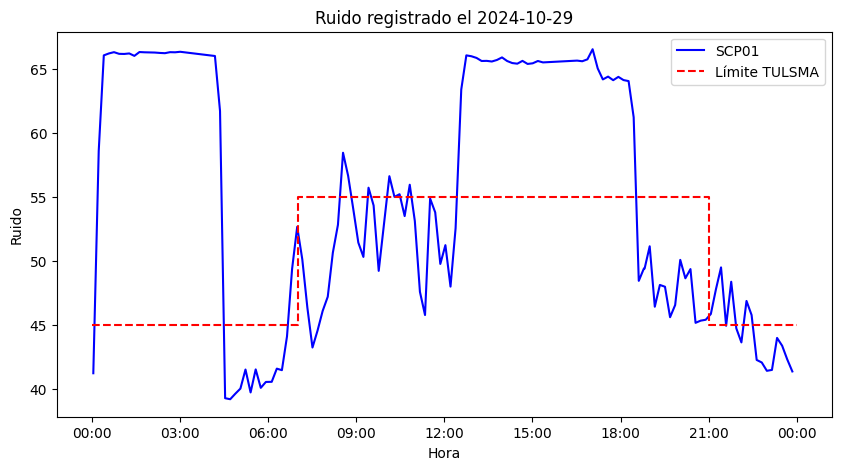

In [52]:
# Graficar ruido
draw_noise_line_chart(date='2024-10-29', df_noise=df_noise, day_limit=55, night_limit=45)

Desde el 31 de octubre al 04 de noviembre, en la zona de la universidad del Azuay no se registraron cortes de luz.

132 datos seleccionados para 2024-10-31
Franja de Sin Corte
Estadístico Shapiro-Wilk: 0.640 Valor p: 0.001


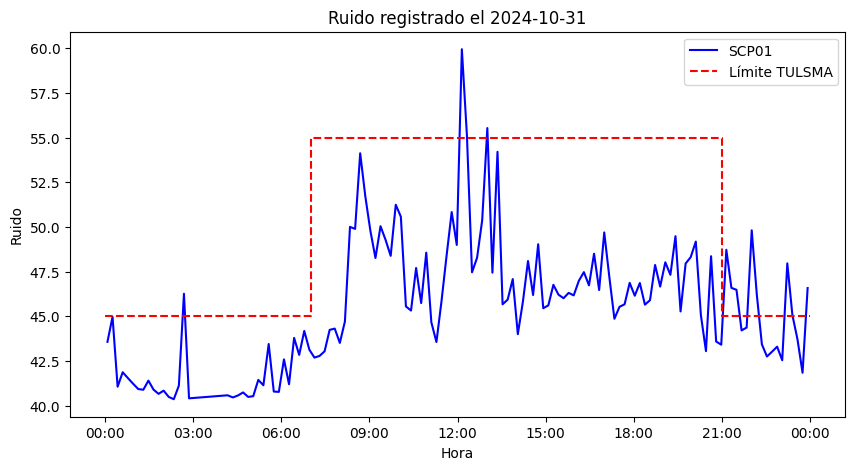

In [53]:
# Graficar ruido
draw_noise_line_chart(date='2024-10-31', df_noise=df_noise, day_limit=55, night_limit=45)

# Clasificar los valores de ruido por franjas de cortes

Se usa la data del 29 de octubre de 2024, día en el que se programó cortes en el servicio eléctrico que suman 8 horas.

In [ ]:
# Función para asignar la franja horaria
def assign_time_slot_sesg(timestamp):
    if ((timestamp.hour == 0 and timestamp.minute > 10) or 
        (timestamp.hour >= 1 and timestamp.hour < 4 ) or
        (timestamp.hour == 4 and timestamp.minute < 30) or
        (timestamp.hour == 12 and timestamp.minute > 30) or
        (timestamp.hour >= 13 and timestamp.hour < 18) or
        (timestamp.hour == 18 and timestamp.minute < 30)):
        return 'Corte programado'
    else:
        return 'Sin corte'

In [42]:
# Función para asignar la franja horaria
def assign_time_slot(timestamp):
    if ((timestamp.hour >= 0 and timestamp.hour < 4) or 
        (timestamp.hour >= 12 and timestamp.hour < 18 )):
        return 'Corte programado'
    else:
        return 'Sin corte'

Verificando visualmente el inicio de funcionamiento del generador

In [43]:
# Seleccionar data del dia
date_noise = '2024-10-29'
desired_date = pd.to_datetime(date_noise).date()  
df_noise_date = df_noise[df_noise['timestamp'].dt.date == desired_date]
print(f"{len(df_noise_date)} datos seleccionados POR INICIO DE GENERADOR para {date_noise}")

# Crea la columna 'franja_horaria' usando una condición
df_noise_date['franja_horaria'] = df_noise_date['timestamp'].apply(assign_time_slot)
print(f"\nValores de ruido clasificados:\n{df_noise_date.head()}")
df_noise_date.to_csv(f"data_ruido/{date_noise}_noise_franjas.csv", index=False)

128 datos seleccionados POR INICIO DE GENERADOR para 2024-10-29

Valores de ruido clasificados:
               timestamp id_wasp sensor  value    franja_horaria
8923 2024-10-29 00:02:24   SCP01  NOISE  41.23  Corte programado
8928 2024-10-29 00:13:28   SCP01  NOISE  58.60  Corte programado
8933 2024-10-29 00:23:52   SCP01  NOISE  66.07  Corte programado
8938 2024-10-29 00:34:16   SCP01  NOISE  66.22  Corte programado
8943 2024-10-29 00:44:41   SCP01  NOISE  66.32  Corte programado


C:\Users\adm\AppData\Local\Temp\ipykernel_23536\4156364998.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_noise_date['franja_horaria'] = df_noise_date['timestamp'].apply(assign_time_slot)


BoxPlot para franjas horarias

C:\Users\adm\AppData\Local\Temp\ipykernel_23536\2466152983.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_noise_date, x='franja_horaria', y='value', palette="coolwarm")


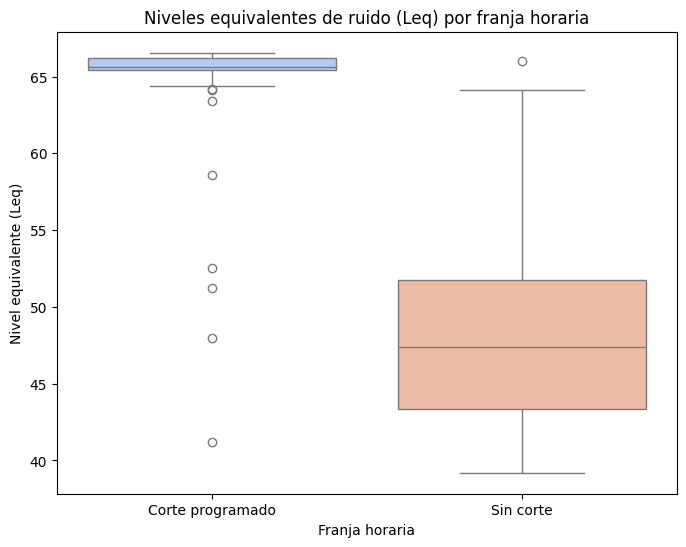

In [44]:
# Crear boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_noise_date, x='franja_horaria', y='value', palette="coolwarm")
plt.title('Niveles equivalentes de ruido (Leq) por franja horaria')
plt.xlabel('Franja horaria')
plt.ylabel('Nivel equivalente (Leq)')
plt.show()

Verificar si los datos de cada franja horaria siguen una distribución normal, con la prueba de Shaphiro-Wilk

In [45]:
# Obtener los estadísticos por franja horaria
stat_w_c, p_value_corte =stats.shapiro(df_noise_date[df_noise_date['franja_horaria'] == 'Corte programado']['value'])
print(f"Franja de Corte programado\nEstadístico Shapiro-Wilk: {stat_w_c:.3f} Valor p: {p_value_corte:.3f}")

stat_w_sc, p_value_scorte =stats.shapiro(df_noise_date[df_noise_date['franja_horaria'] == 'Sin corte']['value'])
print(f"Franja de Sin Corte\nEstadístico Shapiro-Wilk: {stat_w_sc:.3f} Valor p: {p_value_scorte:.3f}")

Franja de Corte programado
Estadístico Shapiro-Wilk: 0.462 Valor p: 0.000
Franja de Sin Corte
Estadístico Shapiro-Wilk: 0.944 Valor p: 0.002


## Histogramas de franjas horarias

### Franja horaria "Sin corte"

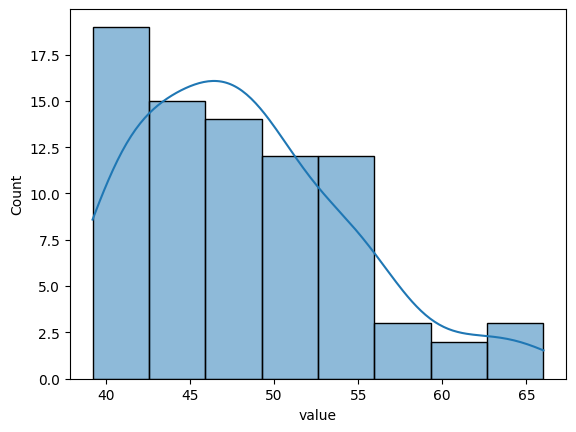

In [46]:
datos = df_noise_date[df_noise_date['franja_horaria'] == 'Sin corte']
sns.histplot(data=datos, x='value', kde=True) # Incluir curva de densidad
plt.show()

### Franja horaria "Corte programado" 

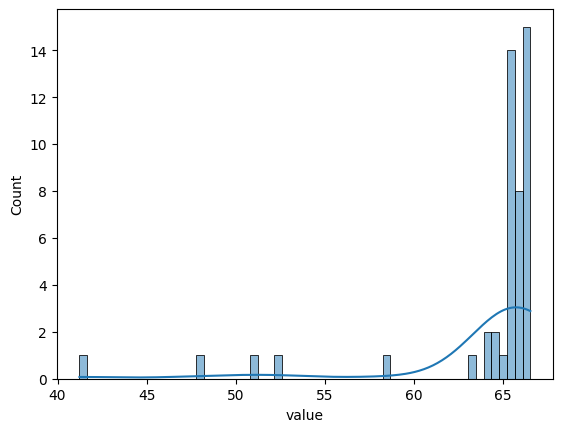

In [47]:
datos = df_noise_date[df_noise_date['franja_horaria'] == 'Corte programado']
sns.histplot(data= datos, x='value', kde=True) # Incluir curva de densidad
plt.show()

# Prueba t de Student
Se trata de un análisis para muestras independientes.
Para franjas horarias con corte programado y sin corte programado

In [54]:
t_stat, p_value = stats.ttest_ind(
    df_noise_date[df_noise_date['franja_horaria'] == 'Corte programado']['value'], 
    df_noise_date[df_noise_date['franja_horaria'] == 'Sin corte']['value'])
print(f'Estadístico t: {t_stat}')
print(f'Valor p: {p_value}')


Estadístico t: 14.736885573658093
Valor p: 3.420534998228695e-29


# Prueba t de student, a detalle

## Grados de libertad

In [55]:
# Obtener dataframes de franjas horarias con corte programado y sin corte programado
df_noise_cp = df_noise_date[df_noise_date['franja_horaria'] == 'Corte programado']
df_noise_sc = df_noise_date[df_noise_date['franja_horaria'] == 'Sin corte']

# Tamano de la muestra con corte y sin corte
n1 = len(df_noise_cp)
n2 = len(df_noise_sc)
print(f"Tamaño de muestras\nn1 = {n1} \nn2 = {n2}")

# Calcular grados de libertad
gl_noise = n1 + n2 - 2
print(f"\nGrados de libertad\ngl = {gl_noise}")

Tamaño de muestras
n1 = 48 
n2 = 80

Grados de libertad
gl = 126


## Estadístico t

In [56]:
# Medias de muestras
x_1 = df_noise_cp['value'].mean()
x_2 = df_noise_sc['value'].mean()
print(f"Medias\nx_1 = {x_1} \nx_2 = {x_2}")

# Desviacion estandar de muestras
s1 = df_noise_cp['value'].std()
s2 = df_noise_sc['value'].std()
print(f"\nDesviación estándar\nS1 = {s1} \nS2 = {s2}")

# Desviacion estandar combinada
sp = np.sqrt(((n1 - 1)*s1**2 + (n2 - 1)*s2**2)/(n1 + n2 -2))
print(f"\nDesviacion estandar combinada\nSp = {sp}")

# Estadístico t
t_stat = (x_1 - x_2)/(sp*np.sqrt((1/n1) + (1/n2)))
print(f"\nValor de estadistico t\nt = {t_stat}")

Medias
x_1 = 64.10083333333333 
x_2 = 48.1835

Desviación estándar
S1 = 5.139815723716062 
S2 = 6.332745140352501

Desviacion estandar combinada
Sp = 5.915959975681244

Valor de estadistico t
t = 14.736885573658093


## Valor crítico de t y p-value

In [57]:
# Significancia de 95%
alpha = 0.05

# Valor crítico unilateral
t_critico_unilateral = t.ppf(1 - alpha, gl_noise)
print(f"Valor crítico t (unilateral, α={alpha}) para grados de libertad = {gl_noise}: {t_critico_unilateral:.4f}")

# Valor crítico bilateral
t_critico_bilateral = t.ppf(1 - alpha / 2, gl_noise)
print(f"Valor crítico t (bilateral, α={alpha}) para grados de libertad = {gl_noise}: {t_critico_bilateral:.4f}")

# Cálculo del valor p para una prueba unilateral
p_value_unilateral = 1 - t.cdf(t_stat, gl_noise)
print(f"Valor p (unilateral) t={t_stat}) : {p_value_unilateral:.4f}")

# Cálculo del valor p para una prueba bilateral
p_value_bilateral = 2 * (1 - t.cdf(abs(t_stat), gl_noise))
print(f"Valor p (bilateral) t={t_stat}) : {p_value_bilateral:.4f}")

Valor crítico t (unilateral, α=0.05) para grados de libertad = 126: 1.6570
Valor crítico t (bilateral, α=0.05) para grados de libertad = 126: 1.9790
Valor p (unilateral) t=14.736885573658093) : 0.0000
Valor p (bilateral) t=14.736885573658093) : 0.0000
